# Codebuster STAT 535 Statistical Computing Project
## Movie recommendation recommendation pipeline

##### Patrick's comments 11/9

- Goal: Build a small real world deployment pipeline like it can be used in netflix / amazon 
- build / test with movie recommendation data set (model fitting, data preprocessing, evaluation)
- Show that it also works with another dataset like product recommendation
 - Find data on UCI repo, kaggle, google search 

- Use scikit learn estimation: https://github.com/scikit-learn-contrib/project-template


## Literature

- https://users.ece.cmu.edu/~dbatra/publications/assets/goel_batra_netflix.pdf
- http://delivery.acm.org/10.1145/1460000/1454012/p11-park.pdf?ip=72.19.68.210&id=1454012&acc=ACTIVE%20SERVICE&key=73B3886B1AEFC4BB%2EB478147E31829731%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&__acm__=1543416754_7f92e0642e26e7ea732886879096c704
- https://www.kaggle.com/prajitdatta/movielens-100k-dataset/kernels
- https://medium.com/@james_aka_yale/the-4-recommendation-engines-that-can-predict-your-movie-tastes-bbec857b8223
- https://www.kaggle.com/c/predict-movie-ratings
- https://cseweb.ucsd.edu/classes/wi17/cse258-a/reports/a048.pdf
- https://github.com/neilsummers/predict_movie_ratings/blob/master/movieratings.py
- https://medium.com/@connectwithghosh/recommender-system-on-the-movielens-using-an-autoencoder-using-tensorflow-in-python-f13d3e8d600d
### A few more
- https://sci2s.ugr.es/keel/pdf/specific/congreso/xia_dong_06.pdf (Uses SMV for classification, then MF for recommendation)
- https://www.kaggle.com/rounakbanik/movie-recommender-systems (Employs at least three Modules for recommendation)
- http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.703.4954&rep=rep1&type=pdf (Close to what we need, but a little too involving)
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0165868 (Uses SVM and correlation matrices...I have already tried the correlation approach, looks quite good, but how to quantify accuracy?)
- https://www.quora.com/How-do-we-use-SVMs-in-a-collaborative-recommendation (A good thread on SVM)
-http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/ (A good tutorial on matrix factorizasion)

## Approach

##### Content-based recommender system
Content-based recommendation information about users and their taste. As we can see in the preprocessing, most of the users only rated one to five movies, implying that we have incomplete user-profiles. I think content-based recommendation does not make to much sense here, except for users with a good user profile. 

Maybe use content-based filtering for users with a high amount of rated movies (>10), otherwise switch to collaborative filtering?

##### Collaborative recommender system
Makes more sense here, as we can look for similar users if user-profile is incomplete (e.g. users that likes the same one movie as our prediction target, but rated more movies)



In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.metrics import classification_report,confusion_matrix


## Data Preprocessing
Get a feeling for the dataset, its problems and conduct helpful preprocessing

In [123]:
df = pd.read_csv("allData.tsv", sep='\t')
print(f"Shape: {df.shape}")
df.head()

Shape: (31620, 10)


,userID,age,gender,movieID,name,year,genre1,genre2,genre3,rating
0,747,1,F,1193,One Flew Over the Cuckoo's Nest,1975,Drama,NaN,NaN,5
1,747,1,F,661,James and the Giant Peach,1996,Animation,Children's,Musical,3
2,747,1,F,2804,"Christmas Story, A",1983,Comedy,Drama,NaN,5
3,747,1,F,919,"Wizard of Oz, The",1939,Adventure,Children's,Drama,4
4,747,1,F,2791,Airplane!,1980,Comedy,NaN,NaN,4


##### Histogram: Number of movies are rated by users
Most users rated only up tp 5 movies

(31620, 10)

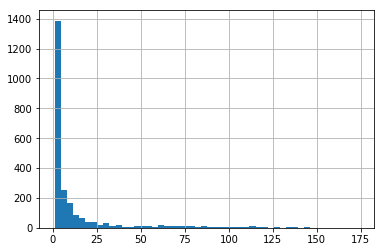

In [144]:
df.userID.value_counts().hist(bins=50)

##### Filter out users with more than 10 ratings -> good user profile
It can be useful to use content-based recommender systems for those users

In [145]:
# count of users with > 10 ratings
df_content = df.copy()
df_content.set_index('userID', inplace=True)

df_content[df.userID.value_counts()>10].shape


/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


(26498, 9)

In [130]:
df_content.groupby('userID').count().movieID.sort_values()

userID
2992      1
3762      1
1607      1
3758      1
3755      1
3716      1
1616      1
1621      1
3712      1
3711      1
3694      1
3678      1
1640      1
3675      1
3661      1
3651      1
1661      1
3642      1
3632      1
3631      1
3627      1
3626      1
1675      1
1676      1
1598      1
3769      1
3784      1
3790      1
3891      1
3882      1
       ... 
634     122
3936    123
52      124
4337    126
1682    127
4133    127
70      132
4169    133
2801    134
2558    134
4383    135
1278    135
896     135
5925    137
1061    137
1274    139
2005    139
3974    141
3795    143
469     143
2185    144
1587    145
1279    148
5032    155
788     155
835     162
1388    164
3487    167
802     171
4435    174
Name: movieID, Length: 2353, dtype: int64

In [86]:
data.dtypes

userID        int64
age           int64
gender     category
movieID       int64
name         object
year          int64
genre1     category
genre2     category
genre3     category
rating        int64
dtype: object

##### Handle categorical and missing data

##### Transform numerical rating to binary
- 1, if user rates movie 4 or 5
- 0, if user rates movie less than 4

In [88]:
df['rating'].mask(df['rating'] < 4, 0, inplace=True)
df['rating'].mask(df['rating'] > 3, 1, inplace=True)

##### Check rating distribution

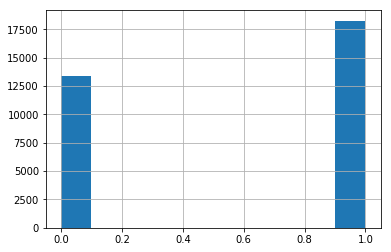

In [89]:
df['rating'].hist()

## Model fitting
##### kNN

## Evaluation
10-fold Cross-validation

In [4]:
# Cross Validation to test and anticipate overfitting problem
def crossvalidate(clf, X,y):
    scores1 = cross_val_score(clf, X, y, cv=10, scoring='precision')
    scores2 = cross_val_score(clf, X, y, cv=10, scoring='recall')
    scores3 = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    # Create and print confusion matrix

In [5]:
# Run classifier with cross-validation and plot ROC curves
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
def get_crossval_roc(clfname, classifier,X,y):
    cv = StratifiedKFold(n_splits=10)
    #classifier = GradientBoostingClassifier()

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange','cyan', 'indigo', 'seagreen', 'yellow'])
    lw = 2

    i = 0
    for (train, test), color in zip(cv.split(X_clean_res, y_clean_res), colors):
        probas_ = classifier.fit(X_clean_res[train], y_clean_res[train]).predict_proba(X_clean_res[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_clean_res[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= cv.get_n_splits(X_clean_res, y_clean_res)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(clfname+' ROC')
    plt.legend(loc="lower right")
    plt.savefig("CrossVal_ROC_"+clfname)
    plt.show()
    
    return

In [34]:
# Crossvalidate and evaluate
print("randomforest")
randomforest = RandomForestClassifier()
crossvalidate(randomforest,X_clean_res,y_clean_res)
get_crossval_roc("randomforest",randomforest,X_clean_res,y_clean_res)

randomforest


NameError: name 'RandomForestClassifier' is not defined

## Ceate predictions for predict.csv